# Fisher 判别分析实验 (Fisher Linear Discriminant Analysis)

## 一、实验目的
1. 理解 Fisher 判别（LDA）的基本原理：通过最大化类间方差与类内方差比值来寻找最佳投影方向，实现数据的分类与降维。   
2. 掌握在实际数据集上应用 Fisher 判别的方法，包括数据预处理、训练/测试划分、降维与分类。  
3. 在不同数据集（低维和高维）上对比实验结果，分析 LDA 的效果与局限性。  
4. 学习交叉验证、可视化与结果分析的基本流程。


## 二、实验要求
- 数据集：  
  - **Iris**（3 类，4 维，150 个样本）；  
  - **Sonar**（2 类，60 维，208 个样本）。  
- 划分方式（三选一，本实验采用 k 折交叉验证）：  
  1. 随机划分训练/测试集，多次实验取平均；  
  2. **k 折交叉验证**（我选择这个）；  
  3. 留一法。  
- 针对不同维数，绘制准确率随投影维数变化的曲线。  
- 给出实验结果、图表，并撰写分析与总结。


## 三、实验内容
1. **理论回顾**：推导 Fisher 判别的目标函数，理解类内散度矩阵 $S_w$ 与类间散度矩阵 $S_b$。  
2. **数据准备**：加载并检查 Iris 与 Sonar 数据集，进行标准化预处理。  
3. **算法实现**：  
   - 使用 sklearn 的 LDA 实现。  
   - 手写 LDA：构造 $S_w, S_b$，求解广义特征值问题，作为对比；  
4. **模型评估**：采用 k 折交叉验证，比较不同投影维数下的分类性能。  
5. **可视化与分析**：  
   - Iris：绘制二维投影散点图；  
   - Iris & Sonar：绘制“准确率 vs 投影维数”曲线。  
6. **总结**：比较两种数据集上 LDA 的表现，讨论优缺点与改进方向。


## 四、实验步骤
1. 导入必要库与函数。  
2. 加载 Iris 和 Sonar 数据集，并进行预处理。  
3. 手写实现 LDA 算法，输出投影矩阵。  
4. 在训练/测试集上进行分类与验证，记录准确率。  
5. 绘制结果曲线与散点图，保存图表。  
6. 分析结果，总结实验结论。

# 以下是实验代码

In [15]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# 载入数据集

In [11]:
#Iris 数据集

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

print('Iris shapes:', X.shape, y.shape)  # (150, 4) (150, 1)
print(X.head())
print(y.head())
print(y.value_counts())
# 转为 numpy 方便后续计算
X_iris = X.values
y_iris = y.values.ravel()
# print(X_iris)
# print(y_iris)

Iris shapes: (150, 4) (150, 1)
   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
         class
0  Iris-setosa
1  Iris-setosa
2  Iris-setosa
3  Iris-setosa
4  Iris-setosa
class          
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [12]:
# Sonar 数据集
# fetch dataset 
connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151) 
  
# data (as pandas dataframes) 
X = connectionist_bench_sonar_mines_vs_rocks.data.features 
y = connectionist_bench_sonar_mines_vs_rocks.data.targets 

print('Sonar shapes',X.shape, y.shape)  # (208, 60) (208, 1)
print(X.head())
print(y.head())
print(y.value_counts())
X_sonar = X.values
y_sonar = y.values.ravel()

Sonar shapes (208, 60) (208, 1)
   Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0      0.0200      0.0371      0.0428      0.0207      0.0954      0.0986   
1      0.0453      0.0523      0.0843      0.0689      0.1183      0.2583   
2      0.0262      0.0582      0.1099      0.1083      0.0974      0.2280   
3      0.0100      0.0171      0.0623      0.0205      0.0205      0.0368   
4      0.0762      0.0666      0.0481      0.0394      0.0590      0.0649   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute51  \
0      0.1539      0.1601      0.3109       0.2111  ...       0.0232   
1      0.2156      0.3481      0.3337       0.2872  ...       0.0125   
2      0.2431      0.3771      0.5598       0.6194  ...       0.0033   
3      0.1098      0.1276      0.0598       0.1264  ...       0.0241   
4      0.1209      0.2467      0.3564       0.4459  ...       0.0156   

   Attribute52  Attribute53  Attribute54  Attribute55  Attribute56  \
0 

### 把标签从字符串编码为整数（Iris: 'Iris-setosa' 等 -> 0/1/2；Sonar: 'R'/'M' -> 0/1）,  
### 并观察一下数据集。

In [32]:
# Iris 编码
le_iris = LabelEncoder()               # 1) 创建 LabelEncoder 对象
y_iris_enc = le_iris.fit_transform(y_iris) # fit + transform：学习类别映射并将字符串标签转换为整数
print("Iris classes (original order):", le_iris.classes_)   # 3) 打印出原始类别的顺序（方便知道编码是哪个对应哪个）
print("Sonar encoded counts (label -> count):", np.unique(y_iris_enc, return_counts=True)) # 4) 查看每个编码的数量
print("Iris encoded sample:", y_iris_enc[::50])    # 5) 查看每隔五十个的编码结果
print("Iris encoded shape:", y_iris_enc.shape)              # 6) 确认形状是 (150,)
# Sonar 编码
le_sonar = LabelEncoder()
y_sonar_enc = le_sonar.fit_transform(y_sonar)
print("\nSonar classes (original order):", le_sonar.classes_)
print("Sonar encoded counts (label -> count):", np.unique(y_sonar_enc, return_counts=True))
print("Sonar encoded sample:", y_sonar_enc[::104])
print("Sonar encoded shape:", y_sonar_enc.shape)

# 类别到编码的映射
print(dict(zip(le_iris.classes_, range(len(le_iris.classes_)))))
print(dict(zip(le_sonar.classes_, range(len(le_sonar.classes_)))))


Iris classes (original order): ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Sonar encoded counts (label -> count): (array([0, 1, 2]), array([50, 50, 50], dtype=int64))
Iris encoded sample: [0 1 2]
Iris encoded shape: (150,)

Sonar classes (original order): ['M' 'R']
Sonar encoded counts (label -> count): (array([0, 1]), array([111,  97], dtype=int64))
Sonar encoded sample: [1 0]
Sonar encoded shape: (208,)
{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
{'M': 0, 'R': 1}


### K折交叉验证（5折）
- 选择 5 折是常用经验值：折数过少可能方差较大，折数过多计算量增加且影响不大。
- 每折保证类别比例与整体数据集一致（StratifiedKFold），避免类别不均衡影响结果。

In [52]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 定义 KFold，K=5
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=== Iris 数据集 ===")
for fold, (train_idx, test_idx) in enumerate(kf.split(X_iris, y_iris_enc), 1):
    print(f"Fold {fold}: 训练集 {len(train_idx)}, 测试集 {len(test_idx)}")

print("\n=== Sonar 数据集 ===")
for fold, (train_idx, test_idx) in enumerate(kf.split(X_sonar, y_sonar_enc), 1):
    print(f"Fold {fold}: 训练集 {len(train_idx)}, 测试集 {len(test_idx)}")


=== Iris 数据集 ===
Fold 1: 训练集 120, 测试集 30
Fold 2: 训练集 120, 测试集 30
Fold 3: 训练集 120, 测试集 30
Fold 4: 训练集 120, 测试集 30
Fold 5: 训练集 120, 测试集 30

=== Sonar 数据集 ===
Fold 1: 训练集 166, 测试集 42
Fold 2: 训练集 166, 测试集 42
Fold 3: 训练集 166, 测试集 42
Fold 4: 训练集 167, 测试集 41
Fold 5: 训练集 167, 测试集 41


In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# 已经创建的 kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_evaluate_lda(X, y, kf):
    """在给定的 StratifiedKFold 上评估 sklearn 的 LDA，返回每折准确率列表。"""
    accs = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        # 1) 切出训练/测试数据
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # 2) 在训练集上 fit 标准化器，然后 transform 训练集和测试集
        scaler = StandardScaler().fit(X_train) # 只在训练集上 fit（避免信息泄露）
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        # 3) 在标准化后的训练集上训练 LDA（sklearn 实现）
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_s, y_train)

        # 4) 在测试集上预测并计算准确率
        y_pred = lda.predict(X_test_s)
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)

        print(f"Fold {fold}: acc = {acc:.4f}")

    return np.array(accs)

# 对 Iris 评估
print("=== Iris CV ===")
accs_iris = cv_evaluate_lda(X_iris, y_iris_enc, kf)
print("Iris mean acc = {:.4f}, std = {:.4f}\n".format(accs_iris.mean(), accs_iris.std()))

# 对 Sonar 评估
print("=== Sonar CV ===")
accs_sonar = cv_evaluate_lda(X_sonar, y_sonar_enc, kf)
print("Sonar mean acc = {:.4f}, std = {:.4f}".format(accs_sonar.mean(), accs_sonar.std()))


=== Iris CV ===
Fold 1: acc = 1.0000
Fold 2: acc = 1.0000
Fold 3: acc = 0.9000
Fold 4: acc = 1.0000
Fold 5: acc = 0.9667
Iris mean acc = 0.9733, std = 0.0389

=== Sonar CV ===
Fold 1: acc = 0.6905
Fold 2: acc = 0.7619
Fold 3: acc = 0.7143
Fold 4: acc = 0.7805
Fold 5: acc = 0.7073
Sonar mean acc = 0.7309, std = 0.0343


### 结果展示表格

In [57]:
import pandas as pd

# 把结果整理成DataFrame
results = pd.DataFrame({
    'Dataset': ['Iris', 'Sonar'],
    'Mean Accuracy': [accs_iris.mean(), accs_sonar.mean()],
    'Std Dev': [accs_iris.std(), accs_sonar.std()]
})

print('=== LDA Cross-Validation Results ===')
print(results)

=== LDA Cross-Validation Results ===
  Dataset  Mean Accuracy   Std Dev
0    Iris       0.973333  0.038873
1   Sonar       0.730894  0.034312


### 可视化

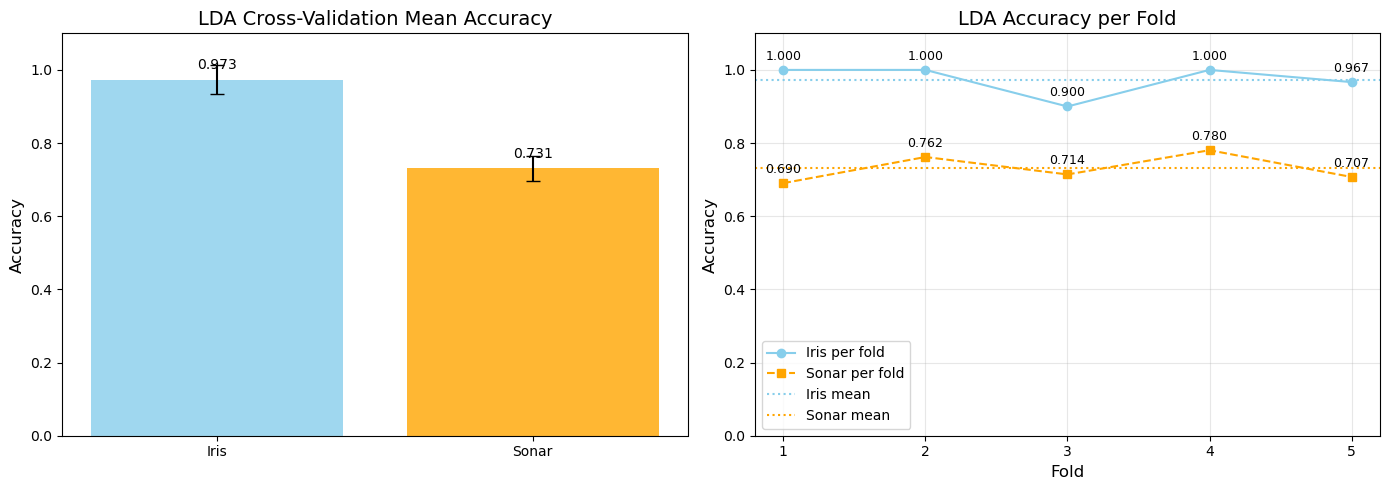

=== LDA Cross-Validation Results ===
  Dataset  Mean Accuracy   Std Dev
0    Iris       0.973333  0.038873
1   Sonar       0.730894  0.034312


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === 准备数据 ===
datasets = ["Iris", "Sonar"]
mean_accs = [accs_iris.mean(), accs_sonar.mean()]
std_accs = [accs_iris.std(), accs_sonar.std()]

folds = np.arange(1, len(accs_iris)+1)

# === 创建 Figure 和子图 ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ----------- 子图 1: 柱状图 -----------
bars = axs[0].bar(datasets, mean_accs, yerr=std_accs, capsize=5, color=["skyblue", "orange"], alpha=0.8)
axs[0].set_title("LDA Cross-Validation Mean Accuracy", fontsize=14)
axs[0].set_ylabel("Accuracy", fontsize=12)
axs[0].set_ylim(0, 1.1)

# 在柱子上标数值
for bar, mean in zip(bars, mean_accs):
    axs[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f"{mean:.3f}", ha='center', va='bottom', fontsize=10)

# ----------- 子图 2: 折线图 -----------
axs[1].plot(folds, accs_iris, marker='o', linestyle='-', color='skyblue', label='Iris per fold')
axs[1].plot(folds, accs_sonar, marker='s', linestyle='--', color='orange', label='Sonar per fold')

# 平均水平线
axs[1].axhline(accs_iris.mean(), color='skyblue', linestyle=':', label='Iris mean')
axs[1].axhline(accs_sonar.mean(), color='orange', linestyle=':', label='Sonar mean')

axs[1].set_title("LDA Accuracy per Fold", fontsize=14)
axs[1].set_xlabel("Fold", fontsize=12)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].set_xticks(folds)
axs[1].set_ylim(0, 1.1)
axs[1].grid(alpha=0.3)
axs[1].legend()

# 在每个折点标数值
for i, acc in enumerate(accs_iris, 1):
    axs[1].text(i, acc + 0.02, f"{acc:.3f}", ha='center', va='bottom', fontsize=9)
for i, acc in enumerate(accs_sonar, 1):
    axs[1].text(i, acc + 0.02, f"{acc:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 实验结果分析

### Iris 数据集
- **平均准确率**：0.973  
- **标准差**：0.039  
- 每折准确率波动小，模型表现稳定  
- **原因**：低维、样本数量充足、类别均衡，类间差异明显  

### Sonar 数据集
- **平均准确率**：0.731  
- **标准差**：0.034  
- 每折准确率波动较小，但整体准确率低于 Iris，模型稳定性一般  
- **原因**：高维、样本相对较少、类内散度矩阵可能接近奇异，模型易受训练划分影响  

### 对比总结
- 低维、多类、大样本的 Iris 数据集，LDA 分类性能高且稳定  
- 高维、少样本的 Sonar 数据集，LDA 分类性能相对较低  
- 数据集维度、样本量和类别分布对 LDA 的表现影响显著



### 以下是附加内容（可不看）

LDA实现

In [50]:
import numpy as np
import numpy.linalg as la
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def lda_fit(X, y, n_components=None, reg=1e-6):
    """
    手写 LDA（多类通用）。
    X: (n_samples, n_features) numpy array
    y: (n_samples,) integer labels 0..c-1
    n_components: desired number of discriminant directions (<= c-1)
    reg: regularization added to S_w for numerical stability
    返回：W 投影矩阵 (n_features, n_components)
    """
    X = np.asarray(X)
    y = np.asarray(y)
    classes = np.unique(y)
    n_features = X.shape[1]
    if n_components is None:
        n_components = min(len(classes)-1, n_features)
    # overall mean
    mean_overall = X.mean(axis=0)
    # within-class scatter S_w and between-class scatter S_b
    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))
    for cl in classes:
        Xc = X[y == cl]
        mean_c = Xc.mean(axis=0)
        # class scatter (within)
        Xc_centered = Xc - mean_c
        S_w += Xc_centered.T @ Xc_centered
        # between
        n_c = Xc.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
        S_b += n_c * (mean_diff @ mean_diff.T)
    # regularize S_w to avoid singularity
    S_w_reg = S_w + reg * np.eye(n_features)
    # solve generalized eigenvalue problem: S_b v = lambda S_w v
    # compute inv(S_w_reg) @ S_b then eig
    mat = la.inv(S_w_reg) @ S_b
    eigvals, eigvecs = la.eig(mat)
    # sort eigenvectors by eigenvalue magnitude descending
    idx = np.argsort(-np.abs(eigvals.real))
    eigvecs = eigvecs.real[:, idx]
    W = eigvecs[:, :n_components]  # each column is a discriminant direction
    return W

def lda_project(X, W):
    """Project X onto columns of W"""
    return np.asarray(X) @ W

class NearestCentroid:
    """简单的最近类均值分类器，用于投影空间"""
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.centroids_ = np.vstack([X[y==c].mean(axis=0) for c in self.classes_])
        return self
    def predict(self, X):
        dists = np.linalg.norm(X[:, None, :] - self.centroids_[None, :, :], axis=2)
        idx = np.argmin(dists, axis=1)
        return self.classes_[idx]

def cv_evaluate_manual_lda(X, y, kf, n_components=None, reg=1e-6):
    """
    在每个 fold:
      - 在训练集上 fit StandardScaler -> transform train/test
      - 在训练集上用手写 lda_fit 计算 W (n_components)
      - 投影 train/test，用 NearestCentroid 分类，计算准确率
    返回每折的准确率数组
    """
    accs = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # 标准化（只在训练集上 fit）
        scaler = StandardScaler().fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        # LDA 拟合：注意 n_components 最大为 c-1
        W = lda_fit(X_train_s, y_train, n_components=n_components, reg=reg)

        # 投影
        X_train_proj = lda_project(X_train_s, W)
        X_test_proj = lda_project(X_test_s, W)

        # 用最近类均值分类
        clf = NearestCentroid().fit(X_train_proj, y_train)
        y_pred = clf.predict(X_test_proj)
        acc = accuracy_score(y_test, y_pred)
        print(f"Fold {fold}: acc = {acc:.4f}")
        accs.append(acc)
    return np.array(accs)


In [51]:
print("=== Iris manual LDA CV ===")
accs_iris_manual = cv_evaluate_manual_lda(X_iris, y_iris_enc, kf, n_components=2, reg=1e-6)
print("Iris mean acc = {:.4f}, std = {:.4f}\n".format(accs_iris_manual.mean(), accs_iris_manual.std()))

print("=== Sonar manual LDA CV ===")
# 对于 Sonar（2 类），最大 n_components = 1，所以传 1
accs_sonar_manual = cv_evaluate_manual_lda(X_sonar, y_sonar_enc, kf, n_components=1, reg=1e-4)
print("Sonar mean acc = {:.4f}, std = {:.4f}".format(accs_sonar_manual.mean(), accs_sonar_manual.std()))


=== Iris manual LDA CV ===
Fold 1: acc = 1.0000
Fold 2: acc = 1.0000
Fold 3: acc = 0.9333
Fold 4: acc = 0.9667
Fold 5: acc = 0.9333
Iris mean acc = 0.9667, std = 0.0298

=== Sonar manual LDA CV ===
Fold 1: acc = 0.6905
Fold 2: acc = 0.7619
Fold 3: acc = 0.6905
Fold 4: acc = 0.8049
Fold 5: acc = 0.7073
Sonar mean acc = 0.7310, std = 0.0453


### 随机训练/测试划分（多次平均）
方法说明：  
- 将数据随机分为训练集和测试集，例如 70% 训练、30% 测试。
- 为了减少划分随机性的影响，重复多次（如 10 次）取平均准确率。

In [66]:
from sklearn.model_selection import train_test_split

def random_split_lda(X, y_enc, n_runs=10, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    accs = []
    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_enc, test_size=test_size, stratify=y_enc, random_state=random_state+i
        )
        # 标准化
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_std, y_train)
        acc = lda.score(X_test_std, y_test)
        accs.append(acc)
    return np.array(accs)

# Iris 数据集
accs_iris_random = random_split_lda(X_iris, y_iris_enc)
print("Iris 随机训练/测试平均准确率:", accs_iris_random.mean())

# Sonar 数据集
accs_sonar_random = random_split_lda(X_sonar, y_sonar_enc)
print("Sonar 随机训练/测试平均准确率:", accs_sonar_random.mean())


Iris 随机训练/测试平均准确率: 0.9822222222222223
Sonar 随机训练/测试平均准确率: 0.738095238095238


### 留一法（Leave-One-Out, LOO） = N折交叉验证
方法说明：
- 每次取一个样本作为测试集，其余作为训练集。
- 对数据集的每一个样本都做一次训练和测试，最后计算整体平均准确率。
- 优点：最大化使用样本，缺点：计算量大（尤其是大样本数据集）。

In [67]:
from sklearn.model_selection import LeaveOneOut

def loo_lda(X, y_enc):
    loo = LeaveOneOut()
    accs = []
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]

        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_std, y_train)
        accs.append(lda.score(X_test_std, y_test))
    return np.array(accs)

# Iris 数据集
accs_iris_loo = loo_lda(X_iris, y_iris_enc)
print("Iris 留一法平均准确率:", accs_iris_loo.mean())

# Sonar 数据集（208 个样本，计算较慢）
accs_sonar_loo = loo_lda(X_sonar, y_sonar_enc)
print("Sonar 留一法平均准确率:", accs_sonar_loo.mean())


Iris 留一法平均准确率: 0.98
Sonar 留一法平均准确率: 0.7548076923076923
